In [1]:
import numpy as np
import astropy.io.fits
import matplotlib.pyplot as plt
import scipy as sym 
import scipy.integrate as integrate
from scipy import log,exp,sqrt,stats
from astropy import units as u
import astropy.constants as const
from scipy.optimize import curve_fit
from astropy.stats import biweight_location, biweight_scale, bootstrap
from astropy.cosmology import LambdaCDM
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
import scipy.stats as stats
from astropy.stats import sigma_clip
c=const.c.to("km/s")
%matplotlib inline
cosmos = LambdaCDM(H0=67.77* u.km / u.Mpc / u.s, Om0=0.307115, Ode0=0.692885)  # define cosmology on the basis of simulation

In [2]:
path_2_data = 'Most_massive_MD04.fits'
print('opening', path_2_data)
my_file=astropy.io.fits.open(path_2_data)
print(my_file[1].data.columns)
data = my_file[1].data

opening Most_massive_MD04.fits
ColDefs(
    name = 'RA_1'; format = 'E'
    name = 'DEC_1'; format = 'E'
    name = 'g_lat_1'; format = 'E'
    name = 'g_lon_1'; format = 'E'
    name = 'ecl_lat_1'; format = 'E'
    name = 'ecl_lon_1'; format = 'E'
    name = 'redshift_R_1'; format = 'E'
    name = 'redshift_S_1'; format = 'E'
    name = 'dL_1'; format = 'E'
    name = 'nH_1'; format = 'E'
    name = 'ebv_1'; format = 'E'
    name = 'galaxy_SMHMR_mass_1'; format = 'E'
    name = 'galaxy_star_formation_rate_1'; format = 'E'
    name = 'galaxy_is_quiescent_1'; format = 'E'
    name = 'galaxy_LX_hard_1'; format = 'E'
    name = 'galaxy_mag_abs_r_1'; format = 'E'
    name = 'galaxy_mag_r_1'; format = 'E'
    name = 'galaxy_UM_A_UV_1'; format = 'E'
    name = 'galaxy_UM_True_SM_1'; format = 'E'
    name = 'galaxy_UM_ICL_mass_1'; format = 'E'
    name = 'galaxy_UM_True_SFR_1'; format = 'E'
    name = 'galaxy_UM_Obs_UV_1'; format = 'E'
    name = 'HALO_id_1'; format = 'K'
    name = 'HALO_pid

In [3]:
# coordinates of the cluster 
# Redshift at the center of the cluster
z_cl = data.field('redshift_R_1')[0] #
ra_cl = data.field('RA_1')[0]*np.pi/180 # radians
dec_cl= data.field('DEC_1')[0]*np.pi/180 # radians    
r_cl = data.field('HALO_Rvir_1')[0]
# coordinates of the sub haloes
z   = data.field('redshift_R_2') # 
ra  = data.field('RA_2') * (np.pi/180) # degrees
dec = data.field('DEC_2') * (np.pi/180) # degrees

# 3D separation in Mpc, to be verified
r = data.field('separation') # Mpc


In [4]:
# Angular separation in radians between sub haloes and the main halo (central halo)
# Uses the haversine method . ADD Link. 
# Angular_separation_Haversine = 2*np.arcsin( np.sqrt(
#                    np.sin( ( (np.pi/2. - (dec_cl)) - (np.pi/2. -dec) ) / 2.0 )**2.0 
#                         +
#                    np.cos(np.pi/2. - (dec_cl)) * np.cos(np.pi/2. -dec) * np.sin((ra_cl-ra) / 2.0) **2.0
#                        )
#               )

In [5]:
# From astropy inbuilt module separation
coordinates_SubHaloes = SkyCoord( ra * 180/np.pi, dec * 180/np.pi, unit='deg', frame='icrs') 
coordinate_cluster    = SkyCoord( ra_cl * 180/np.pi, dec_cl*180/np.pi, unit='deg', frame='icrs') 
Angular_separation_Astropy = coordinates_SubHaloes.separation( coordinate_cluster )
Angular_separation_Astropy_radian = (Angular_separation_Astropy).to(u.radian)

In [6]:
# Comoving distance
D = cosmos.comoving_distance(z_cl) 
print('the cluster at redshift ',z_cl,' is at dC=',D)

the cluster at redshift  0.33398816  is at dC= 1359.1182184541588 Mpc


In [7]:
# Angular diameter distance
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl), 'per radian')
print('Angular diameter distance at the clusters redshift :' , cosmos.angular_diameter_distance(z_cl)/(180/np.pi), 'per degree')
print('Angular diameter distance at the clusters redshift :' , (cosmos.angular_diameter_distance(z_cl)/(180/np.pi)).to(u.kpc)/60, 'per arc minute    ')

Angular diameter distance at the clusters redshift : 1018.8382920589 Mpc per radian
Angular diameter distance at the clusters redshift : 17.7820827418234 Mpc per degree
Angular diameter distance at the clusters redshift : 296.3680456970567 kpc per arc minute    


In [8]:
# The angular separation between sub haloes and the cluster converted in Mpc
r_proj =  Angular_separation_Astropy_radian * cosmos.angular_diameter_distance(z_cl)/u.radian  # where D is comoving distance
print('min, max projected distance : ',r_proj.min(), r_proj.max(), 'compared to the 3D virial radius', r_cl/1000)

min, max projected distance :  0.0 Mpc 1.4157164096832275 Mpc compared to the 3D virial radius 1.9035889892578124


In [9]:
r_proj

<Quantity [0.        , 0.49019653, 0.69688416, 1.0059068 , 0.8654601 ,
           0.20717607, 0.50522745, 0.38944122, 1.3848695 , 1.3102907 ,
           0.93018603, 1.2386857 , 0.7621069 , 0.55050886, 0.2540283 ,
           0.556539  , 0.4209276 , 0.7711804 , 0.37255323, 0.9000288 ,
           0.662444  , 0.43419573, 0.9776623 , 1.2258475 , 0.25600204,
           0.59628385, 0.49099118, 1.0920981 , 0.91486526, 1.215047  ,
           0.32858166, 1.3952022 , 0.8020621 , 0.42956528, 0.65484506,
           1.2380083 , 0.82404876, 0.30107   , 0.4267139 , 0.6797997 ,
           0.9187256 , 0.95162123, 0.30537707, 0.9421333 , 1.0403689 ,
           0.55721825, 1.2118609 , 1.1390077 , 0.75161093, 1.3042675 ,
           0.55234754, 1.112286  , 0.88488245, 1.068759  , 0.4514486 ,
           0.43430382, 0.9535652 , 0.8524852 , 0.6449321 , 0.91730404,
           1.3752757 , 0.57076937, 0.58611095, 0.13352363, 0.50282395,
           1.0469046 , 0.2759897 , 0.8980826 , 1.3558915 , 0.96845025,
      

In [10]:
# interpolated conversion between redshift and comoving distance
d_C = cosmos.comoving_distance(z)
dc_mpc = (d_C).value
dc_interpolation = interp1d(z, dc_mpc)
z_interpolation = interp1d(dc_mpc, z)


In [11]:
#rr    = dc_interpolation( ZZZZ )

In [12]:
D_cl=cosmos.comoving_distance(z)
d_C = D_cl
dc_mpc = (d_C).value
dc_interpolation = interp1d(z, dc_mpc)
z_interpolation = interp1d(dc_mpc, z)
def get_x_y_z(ra_radian, dec_radian, rr):
    phi   = ( ra_radian*180/np.pi   - 180 ) * np.pi / 180.
    theta = (dec_radian*180/np.pi + 90 ) * np.pi / 180.
    xx = rr * np.cos( phi) * np.sin( theta )
    yy = rr * np.sin( phi) * np.sin( theta )
    zz = rr * np.cos( theta )
    return xx, yy, zz

# get 3D Cartesian positions of the sub haloes
xx, yy, zz = get_x_y_z(ra, dec, dc_interpolation(z))

print('x mean, std',np.mean(data.field('HALO_x_2')-xx), np.std(data.field('HALO_x_2')-xx))
print('x mean, std',np.mean(data.field('HALO_y_2')-yy), np.std(data.field('HALO_y_2')-yy))
print('x mean, std',np.mean(data.field('HALO_z_2')-zz), np.std(data.field('HALO_z_2')-zz))

# get 3D Cartesian positions of the cluster
xx_cl, yy_cl, zz_cl = get_x_y_z(ra_cl, dec_cl, dc_interpolation(z_cl))
print('ra,dec,z=',ra_cl, dec_cl, z_cl, '\n x,y,z=',xx_cl, yy_cl, zz_cl)

# array of distances between sub haloes and the cluster : 
distances = np.sqrt((xx_cl-xx)**2 + (yy_cl-yy)**2 + (zz_cl-zz)**2)

x mean, std -2.2749552953386206e-05 0.0004152230923755402
x mean, std -0.00023499888141364963 0.00042522407380780745
x mean, std 4.557050177504702e-05 0.00010263843485104863
ra,dec,z= 5.577616462721699 -0.08096291842468864 0.33398816 
 x,y,z= -1031.229798280288 878.4561999014163 109.91799506367586


In [29]:
len(bins_3D) 

20

/tmp/ipykernel_13023/3106661704.py:16: RuntimeWarning: divide by zero encountered in power
  plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/2, ls='')
/tmp/ipykernel_13023/3106661704.py:16: RuntimeWarning: invalid value encountered in multiply
  plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/2, ls='')


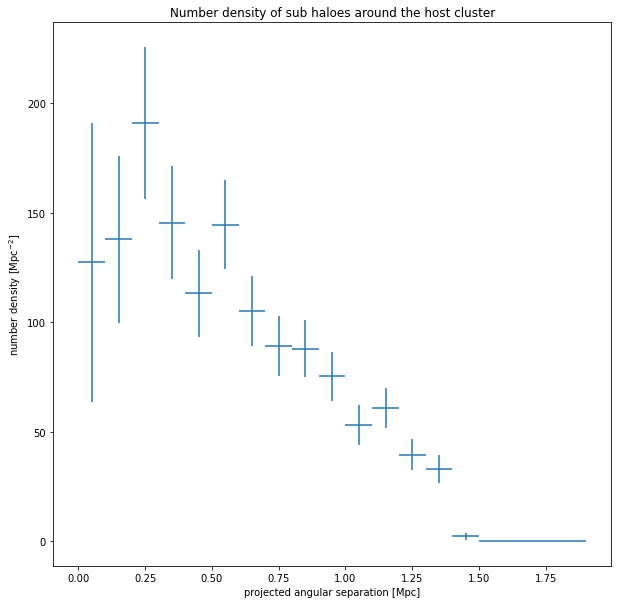

In [35]:
# create histogram of distances in Mpc
dR = 0.1
r_bins = np.arange(0., 2, dR)
# Projected distance
N_2D, bins_2D = np.histogram(np.array(r_proj), bins = r_bins)
# Three D distance
N_3D, bins_3D = np.histogram(np.array(distances), bins = r_bins)

#Getting the number density profile in 2D 
n_2D = N_2D /(np.pi*( ( bins_2D[1:]**2 - bins_2D[:-1]**2) ) )

# central point of each separation 
R_2D = (bins_2D[1:] + bins_2D[:-1])/2.
plt.figure(0, (10, 10))
#plt.plot(R_2D, n_2D, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.errorbar(R_2D, n_2D, yerr=n_2D*N_2D**-0.5, xerr=dR/2, ls='')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Number density of sub haloes around the host cluster')
plt.xlabel('projected angular separation [Mpc]')
plt.ylabel(r'number density [Mpc$^{-2}$]')  
plt.show()


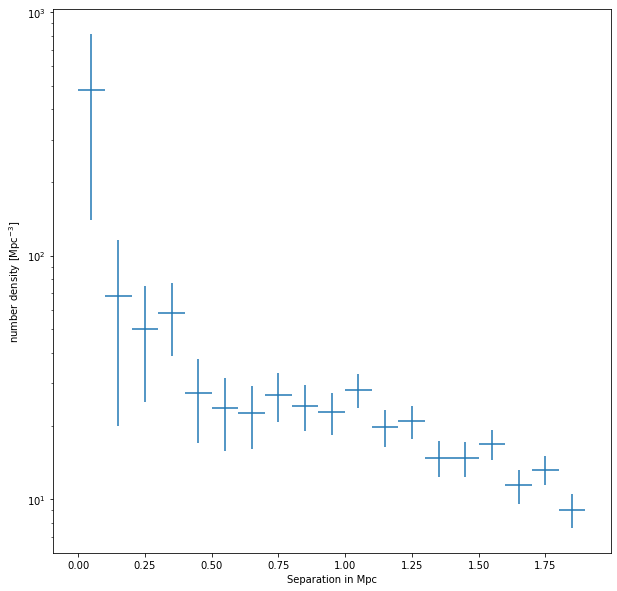

In [32]:
#Ns,rs=np.histogram(r)
number_density = N_3D/(np.pi*( 4* ( bins_3D[1:]**3-bins_3D[:-1]**3) / 3))

r_act = (bins_3D[1:] + bins_3D[:-1])/2.
#plt.xscale('log')
#plt.yscale('log')
plt.figure(0, (10, 10))
plt.errorbar(r_act, number_density, xerr=dR/2., ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
#plt.plot(r_act, number_density, color='black', linestyle='dashed', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Separation in Mpc')
plt.ylabel(r'number density [Mpc$^{-3}$]')
plt.yscale('log')
plt.show()
r_array = np.arange(0.05, 1.9, 0.01)

In [24]:
"""
The interplation of dndR for solving the integral first of all 
Stacking the Proj and dndR

""" 
#Getting the derivative term of n wrt R_proj  ie dndR
dndR = np.array(np.gradient(n_2D,R_2D))
n_2D_no0 = N_2D
n_2D_no0[N_2D==0] = 1

dndR_up = np.array(np.gradient( n_2D + n_2D * n_2D_no0**-0.5, R_2D ))
dndR_low = np.array(np.gradient( n_2D - n_2D * n_2D_no0**-0.5, R_2D ))

def get_nu_all(dndR):
    xx = np.hstack((np.array([0]),np.array(R_2D), np.array([10.]) ))
    yy = np.hstack((np.array(dndR[0]),np.array(dndR), np.array([0.]) ))

    # getting the interpolation
    inter1 = interp1d(xx, yy, bounds_error=True)

    # De-projection of the number density profile from 
    # 2D to 3D using the Abel inversion equation

    def nu(R, r):
        """
        Latex equation
        Reference to the article it comes from
        """
        return (-1/np.pi)*(inter1(R)/((R**2 - r**2)**0.5))

    r_array = np.arange(0.05, 1.9, 0.01)
    nu_all=[integrate.quad(nu, r_i, 1.9, args=(r_i))[0] for r_i in r_array]
    return nu_all

nu_all = get_nu_all(dndR)
nu_all_up = get_nu_all(dndR_up)
nu_all_low = get_nu_all(dndR_low)



/tmp/ipykernel_13023/3018867014.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  nu_all=[integrate.quad(nu, r_i, 1.9, args=(r_i))[0] for r_i in r_array]
/tmp/ipykernel_13023/3018867014.py:32: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  nu_all=[integrate.quad(nu, r_i, 1.9, args=(r_i))[0] for r_i in r_array]
/tmp/ipykernel_13023/3018867014.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  nu_all=[integrate.quad(nu, r_i, 

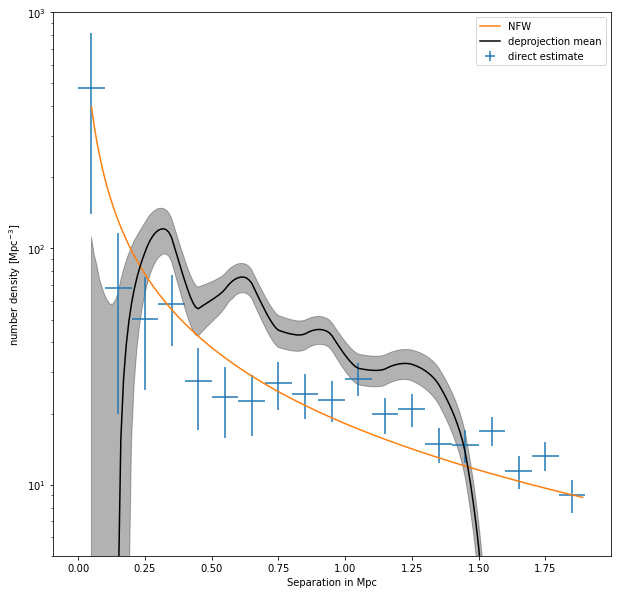

In [19]:
# plotting the de-projected number density wrt actual distance from the cluster center
from colossus.halo import profile_nfw

#Rvir = 1.1
#c = 10.0
Rs=20 #Rs = Rvir / c
rhos = 1.0

p_nfw = profile_nfw.NFWProfile(rhos , Rs)

#r = np.arange(0,2,0.1)
#rho_m = cosmo.rho_m(z)
rho_nfw = p_nfw.density(r_array)

plt.figure(0, (10, 10))
plt.errorbar(r_act, number_density, xerr=dR/2., ls='', yerr=number_density * N_3D**-0.5, label='direct estimate')
plt.plot(r_array, 1*rho_nfw , label = 'NFW');
plt.plot(r_array, nu_all, label='deprojection mean', c='k')
plt.fill_between(r_array, y1=nu_all_low, y2=nu_all_up, alpha=0.3, color='k')
plt.xlabel('Separation in Mpc')
plt.ylabel(r'number density [Mpc$^{-3}$]')
plt.yscale('log')
plt.ylim((5, 1e3))
plt.legend()
plt.show()


In [ ]:
print(bins_2D== bins_3D, bins_2D)

In [ ]:
# Create a "true" NFW profile
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');


In [ ]:
np.sort(c*z)

In [ ]:
c*z_cl

In [ ]:
(c*z)-c*z_cl

In [ ]:
# Peculiar velocities of a members from there spectrosocpic
# redshift and mean redshift of a cluster

c=const.c.to("km/s")

los_v= c*(z -  z_cl)/(1 + z_cl)
los_v
plt.plot(r_proj,los_v, color='black', linestyle='none', linewidth = 2, marker='o', markerfacecolor='green', markersize=12)
plt.xlabel('Separation in Mpc')
plt.ylabel('Peculiar velocity in clusters frame')
plt.show()

In [ ]:
# from the simulation file haing X,Y and Z component of velocity just for comparision
v=np.sqrt(data.HALO_vx_2**2+data.HALO_vy_2**2+data.HALO_vz_2**2)
v.min()